We will try various ways to represent and understand the relationship between documents.

In [52]:
import pandas as pd
import numpy as np
import os

from config import RAW_DATA_PATH

import time

from tqdm import tqdm

import csv

In [2]:
df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'CADA-2022-05-31.csv'), sep=',')

In [3]:
documents = df['Avis'].values.tolist()

In [4]:
len(df)

48746

# Basic tokenization

There are different ways to encode documents into tokens.

Let's use the SpacY tokenizer with default settings on French vocab.

In [6]:
from spacy.tokenizer import Tokenizer
from spacy.lang.fr import French
from spacy import load

nlp = load('fr_core_news_sm')
def document_preprocessing(document):
    """Normalize documents with some preprocessing tasks"""
    
    document = nlp(str(document).lower())
    
    # remove stopwords, punctuation and numeric values
    tokens = [tk for tk in document if
                  tk.is_stop is False and
                  tk.is_punct is False and
                  tk.like_num is False
             ]
    
    # lemmatize
    tokens = [token.lemma_ for token in tokens]
    
    return tokens

In [16]:
%%time

document_tokens = []
array_tokens = []

for idx, doc in tqdm(enumerate(documents)):

    token_list = document_preprocessing(document=doc)

    document_tokens.append(' '.join(token_list))
    array_tokens.append(token_list)


48746it [30:12, 26.89it/s]

CPU times: user 27min 12s, sys: 3min 1s, total: 30min 13s
Wall time: 30min 12s


In [53]:
# dump to txt file
with open('data/preprocessing/document_tokens_2022_12_11.txt', 'w', newline='') as f:
    for doc in document_tokens:
        doc = doc.replace('\n\n', '')
        doc = doc.replace('\n', '')
        f.write(f'%s\n' % doc)

In [55]:
documents_new = []
with open('data/preprocessing/document_tokens_2022_12_11.txt', 'r') as f:
    for lines in f:
        documents_new.append(lines)

In [ ]:
document_tokens_clean
for doc in document_tokens:
    doc = doc.replace('\n\n', '')
    doc = doc.replace('\n', '')

In [58]:
df['document_tokens'] = document_tokens

In [ ]:
df.to_csv('data/preprocessing/')

In [70]:
for doc in array_tokens:
    if '\n\n' in doc:
        doc.remove('\n\n')

In [86]:
from keras.preprocessing.text import text_to_word_sequence

CLASSES = ['favorable', 'défavorable', 'sans objet']

def create_label(raw_label):
    """Create normalized label from raw values"""
    
    tokens = text_to_word_sequence(str(raw_label), split='/')
    tokens = [x.strip() for x in tokens]
    
    normalised_labels = []
    for label in CLASSES:
        if label in tokens:
            normalised_labels.append(label)
    if len(normalised_labels) == 1:
        return normalised_labels[0]

df['label'] = df['Sens et motivation'].apply(create_label)

In [87]:
df['document_tokens'] = ['|'.join(doc) for doc in array_tokens]

In [88]:
df[['document_tokens','label']].to_csv('data/preprocessing/document_tokens_labelled.csv', sep=',', index=False)

# Bert WordPiece tokenizer

# Word vectors

We need to map documents into a feature space.

## Word frequencies

Consider a document as a vector of size `N` which is the vocabulary size.

We encode all tokens of the document into this vector.

The vector values are based on TFIDF approach:
* The numerator is the token frequency within the document
* The denominator is the token frequency within the whole collection of documents.

Ideas of improvement: consider word-grams

In [428]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

In [429]:
tfidf = TfidfVectorizer(
    analyzer='word',
    max_df=10000,  # ignore tokens that appear more than X times in the document collection
    use_idf=True,
    smooth_idf=True,
    max_features=10000,   # capping on vocabulary size
)
tfidf = tfidf.fit(document_tokens)

X = tfidf.transform(document_tokens)

tfidf_feature_names = tfidf.get_feature_names_out()

In [430]:
# do not use IDF
tf = TfidfVectorizer(
    analyzer='word',
    max_df=10000,  # ignore tokens that appear more than X times in the document collection
    max_features=10000,   # capping on vocabulary size
)
tf = tf.fit(document_tokens)

X_tf = tfidf.transform(document_tokens)

tf_feature_names = tf.get_feature_names_out()

In [431]:
print('Matrix size:', X.shape[0], 'documents,', X.shape[1], 'vocabulary size')

Matrix size: 48746 documents, 10000 vocabulary size


In [432]:
X

<48746x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3000501 stored elements in Compressed Sparse Row format>

Now we can build the distance matrix, which represents the distance between documents.

The computation cost is quadratic. Let's take the first 15k documents for the moment.

In [129]:
DATASET_TRUNCATION = 15000

In [106]:
distance_matrix = cosine_similarity(X[:DATASET_TRUNCATION,:], dense_output=False)

In [107]:
distance_matrix

<15000x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 201824095 stored elements in Compressed Sparse Row format>

## Pre-trained embeddings

# Topic modelling

Extract topics from documents.

In [433]:
from sklearn.decomposition import LatentDirichletAllocation

In [434]:
lda = LatentDirichletAllocation(n_components=10)

In [435]:
lda = lda.fit(X_tf[:DATASET_TRUNCATION,:])

In [436]:
import matplotlib.pyplot as plt


def plot_top_words(model, feature_names, n_top_words, title):
    """
    source sklearn API documentation
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

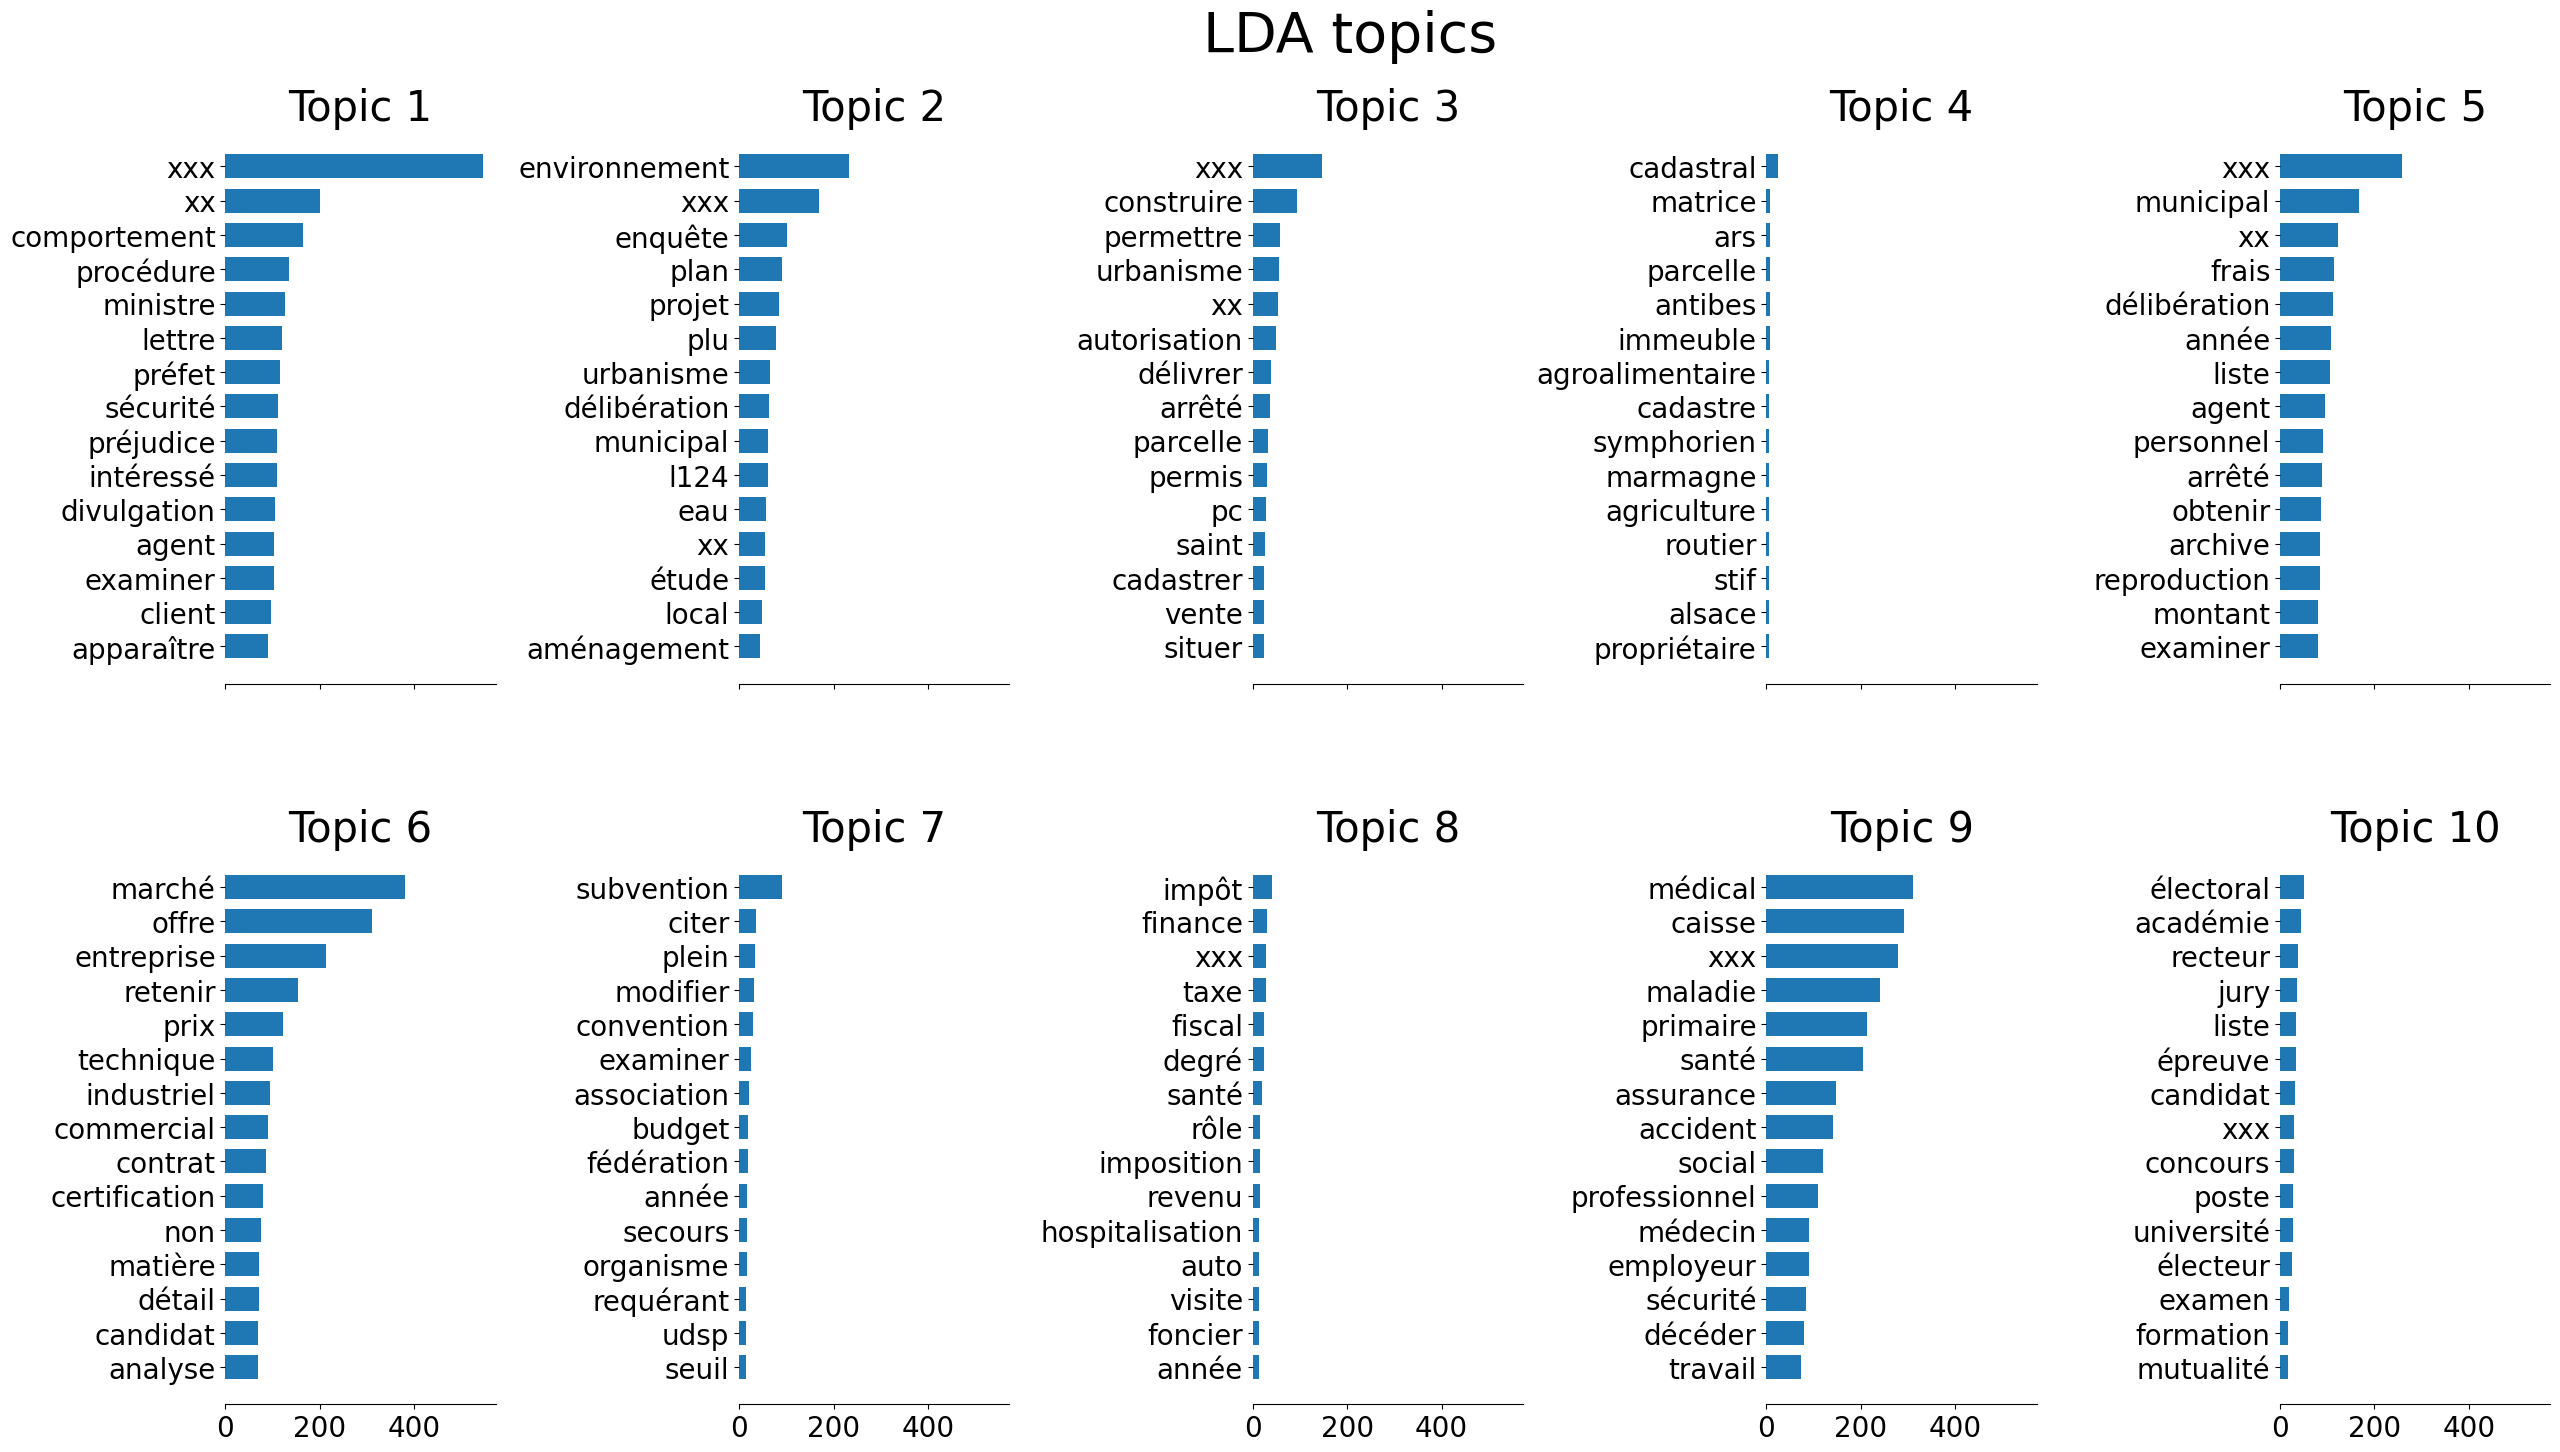

In [440]:
plot_top_words(model=lda, feature_names=tf_feature_names, n_top_words=15, title="LDA topics")